<a href="https://colab.research.google.com/github/mark-ford123/applied_ml_cw_2025_mf/blob/main/coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

!kaggle datasets download -d nolasthitnotomorrow/radioml2016-deepsigcom --unzip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/nolasthitnotomorrow/radioml2016-deepsigcom
License(s): CC-BY-NC-SA-4.0


In [ ]:
import pickle
with open("RML2016.10a_dict.pkl", "rb") as f:
  Xd = pickle._Unpickler(f)
  Xd.encoding = "latin1"
  Xd = Xd.load()

In [ ]:
# Load the dataset (already unpickled)
Xd_dict = Xd  # Assuming Xd is your unpickled dataset

# Extract Modulations and SNRs
modulations = sorted(set([key[0] for key in Xd_dict.keys()]))  # Unique modulation types
snrs = sorted(set([key[1] for key in Xd_dict.keys()]))  # Unique SNR values

X = []  # Features (IQ samples)
y = []  # Labels (Modulation type)

# Iterate through the dictionary and extract data
for (mod_type, snr), samples in Xd_dict.items():
    for sample in samples:
        X.append(sample)  # Each sample is (2, 128)
        y.append(mod_type)  # The label is the modulation type

# Convert lists to NumPy arrays
X = np.array(X)  # Shape: (num_samples, 2, 128)
y = np.array(y)  # Shape: (num_samples,)

# Convert modulation labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert to integers

# One-hot encode the labels for TensorFlow
y_onehot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(modulations))

# Split the dataset into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot)

# Print dataset shapes
print(f"X_train shape: {X_train.shape}")  # (num_samples, 2, 128)
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")  # (num_samples, num_classes)
print(f"y_test shape: {y_test.shape}")


X_train shape: (176000, 2, 128)
X_test shape: (44000, 2, 128)
y_train shape: (176000, 11)
y_test shape: (44000, 11)


The data is split into two sections; data used to train the model, and data used to evaluate its prediction accuracy. The 80/20 split for training/testing is fairly standard within the industry. Increasing the amount of training data gives the model more data to learn from, but a generally less reliable evaluation. Whereas decreasing the amount of training data allows for better evaluations, but possibly poor generalizations, as it has not learnt as well. 80/20 strikes a good middle-ground.

In [ ]:
# Reshape for CNN (channels last format)
X_train = X_train.reshape(-1, 128, 2, 1)  # Add a channel dimension
X_test = X_test.reshape(-1, 128, 2, 1)

print(f"Reshaped X_train: {X_train.shape}")  # (num_samples, 128, 2, 1)
print(f"Reshaped X_test: {X_test.shape}")


Reshaped X_train: (176000, 128, 2, 1)
Reshaped X_test: (44000, 128, 2, 1)


In [ ]:
# Define CNN Model
model = Sequential([
    Input(shape=(128,2,1)),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding="same", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,1)),

    Conv2D(128, kernel_size=(3,3), activation='relu', padding="same", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,1)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),  # Reduce dropout slightly
    Dense(11, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train Model with Early Stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,  # Allow more training time
    batch_size=128,  # ✅ Reduced batch size (was 256)
    callbacks=[early_stop, lr_scheduler]
)

# ✅ Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2%}")


Epoch 1/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.3172 - loss: 2.4305 - val_accuracy: 0.4606 - val_loss: 1.9473 - learning_rate: 5.0000e-05
Epoch 2/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.4508 - loss: 1.9289 - val_accuracy: 0.4949 - val_loss: 1.7628 - learning_rate: 5.0000e-05
Epoch 3/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.4891 - loss: 1.7504 - val_accuracy: 0.4868 - val_loss: 1.6811 - learning_rate: 5.0000e-05
Epoch 4/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5081 - loss: 1.6347 - val_accuracy: 0.5223 - val_loss: 1.5709 - learning_rate: 5.0000e-05
Epoch 5/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.5249 - loss: 1.5481 - val_accuracy: 0.5269 - val_loss: 1.5144 - learning_rate: 5.0000e-05
Epoch 6/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5338 - loss: 1.4846 - val_accuracy: 0.5237 - val_loss: 1.4817 - learning_rate: 5.0000e-05
Epoch 7/30
1375/1375 ━━━━━━━━━━━━━━━━━━━

This has implemented a **Convolutional Neural Network**.

In [ ]:
# Define CNN-LSTM Model
model_cnn_lstm = Sequential([
    Input(shape=(128, 2, 1)),  # Input shape (128 time steps, 2 features, 1 channel)

    # CNN Layer 1
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),

    # CNN Layer 2
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 1)),

    # Reshape to make it compatible with LSTM
    Reshape((64, 128)),  # Reshape the output to (batch_size, time_steps, features)

    # LSTM Layer
    LSTM(128, return_sequences=True),  # Set return_sequences=True for stacking with another LSTM if needed
    LSTM(64),  # Add another LSTM layer for more complex sequence modeling

    # Fully Connected Layers
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(11, activation='softmax')  # Assuming 11 classes for classification
])

# Compile Model
model_cnn_lstm.compile(optimizer=Adam(learning_rate=0.00005),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train Model with Early Stopping and Learning Rate Scheduler
history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,  # Allow more training time
    batch_size=128,  # Batch size
    callbacks=[early_stop, lr_scheduler]
)

# Evaluate Model
test_loss_cnn_lstm, test_acc_cnn_lstm = model_cnn_lstm.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc_cnn_lstm:.2%}")


Epoch 1/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.2736 - loss: 2.1625 - val_accuracy: 0.4028 - val_loss: 1.7466 - learning_rate: 5.0000e-05
Epoch 2/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.4308 - loss: 1.6638 - val_accuracy: 0.4852 - val_loss: 1.5300 - learning_rate: 5.0000e-05
Epoch 3/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.4747 - loss: 1.5366 - val_accuracy: 0.4589 - val_loss: 1.5905 - learning_rate: 5.0000e-05
Epoch 4/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.4922 - loss: 1.4754 - val_accuracy: 0.4665 - val_loss: 1.5175 - learning_rate: 5.0000e-05
Epoch 5/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.5042 - loss: 1.4338 - val_accuracy: 0.3976 - val_loss: 1.8145 - learning_rate: 5.0000e-05
Epoch 6/30
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.5096 - loss: 1.4129 - val_accuracy: 0.5122 - val_loss: 1.4006 - learning_rate: 5.0000e-05
Epoch 7/30
1375/1375 ━━━━━━━━━━━━━━━━━━━

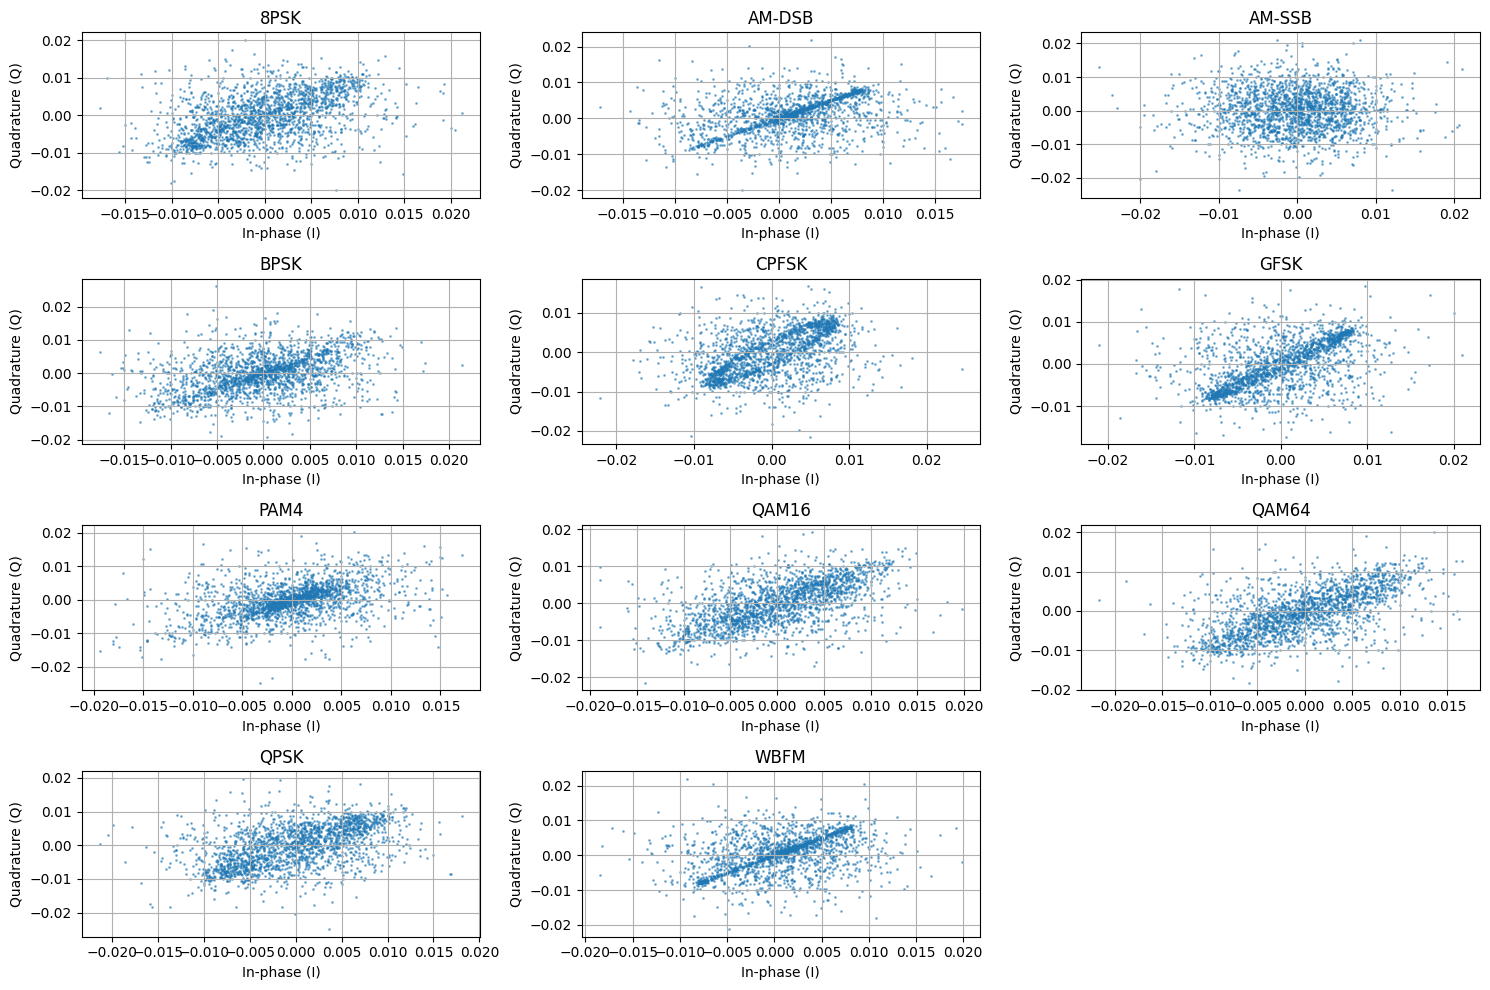

In [ ]:
# Select a subset of the dataset for visualization
def plot_constellation(X_data, y_data, modulations, num_samples=1000):
    """
    Plots constellation diagrams for different modulation types.

    X_data: IQ samples (shape: samples x 2 x 128)
    y_data: Labels (one-hot encoded)
    modulations: List of modulation names
    num_samples: Number of points to plot per modulation type
    """

    # Convert one-hot encoding to integer labels
    labels = np.argmax(y_data, axis=1)

    # Set up the plot
    plt.figure(figsize=(15, 10))

    for mod_idx, modulation in enumerate(modulations):
        plt.subplot(4, 3, mod_idx + 1)  # Adjust grid based on modulation count

        # Extract samples belonging to the current modulation type
        iq_samples = X_data[labels == mod_idx][:num_samples]  # Select samples

        # Reshape and take I/Q components
        I = iq_samples[:, 0, :].flatten()  # In-phase component
        Q = iq_samples[:, 1, :].flatten()  # Quadrature component

        # Scatter plot
        plt.scatter(I, Q, alpha=0.5, s=1)
        plt.title(modulation)
        plt.xlabel("In-phase (I)")
        plt.ylabel("Quadrature (Q)")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call function to visualize
plot_constellation(X_train, y_train, modulations)


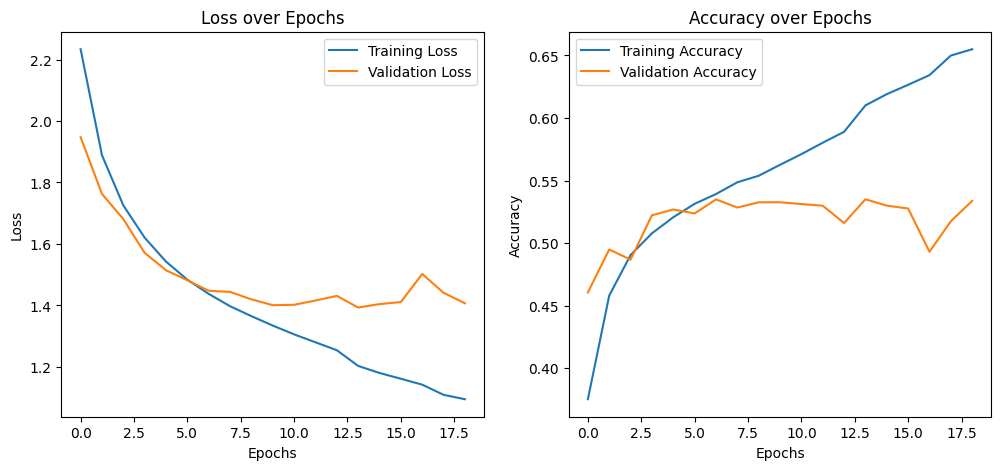

In [ ]:
# Extract values from history
epochs = range(len(history.history['loss']))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.show()


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


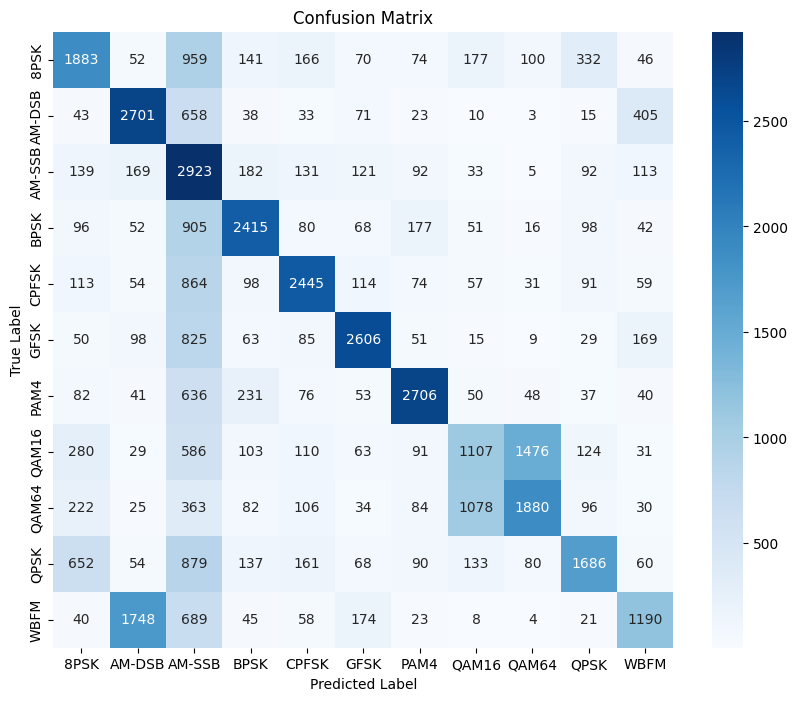

In [ ]:
# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class index
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class index

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()